# Additional QAOA parameter classes

This notebook demonstrates the use of the `Annealing` and `Fourier` parameter classes included in the `entropica_qaoa` package.

In [1]:
# import the standard modules from python
import numpy as np
import matplotlib.pyplot as plt

# import the neccesary pyquil modules
from pyquil.paulis import PauliSum, PauliTerm

# import the QAOAParameters classes 
from entropica_qaoa.qaoa.parameters import AbstractParams, AnnealingParams, FourierParams

## The `Annealing` parameter class

In quantum annealing, we start in the ground state of a _mixer_ (or _reference_) Hamiltonian $H_0$, and gradually transform to the ground state of a _cost_ Hamiltonian $H_C$ according to some annealing schedule function $s(t)$. If the transformation is infintessimally slow, we are guaranteed to arrive at the exact ground state of the cost Hamiltonian. If the transformation is performed over some finite time, we hope to prepare the ground state of $H_C$ with some acceptably high probability.

At any time $t$ during the procedure, the instantaneous Hamiltonian is given by

\begin{equation}
H(t) = \left(1 - s(t)\right)H_0 + s(t)H_C
\end{equation}

where $s(0) = 0$, and $s(t = T) = 1$, and $T$ is the total annealing time. We see that the strengths with which $H_0$ and $H_C$ act at a given time are related: the mixer is applied with a weight $(1 - s(t))$, and the cost Hamiltonian with weight $s(t)$. 

The QAOA can be viewed as a form of discretised annealing, where the procedure is performed in a fixed number of steps commonly denoted $p$. Furthermore, the coefficients of the mixer and cost Hamiltonians need not be related in the simple way that they are in a conventional annealing schedule.

The `AnnealingParams` parameter class illustrates what is perhaps the first conceptual step towards the more conventionally used parametrisations of QAOA. Using `AnnealingParams`, we prepare an output quantum state with a circuit described by the unitary operator

\begin{equation}
U = \exp\left(-i(1-s(t_p)) H_0 \Delta t\right)\exp\left(-i s(t_p) H_c \Delta t\right) \cdots \exp\left(-i(1-s(t_1)H_0 \Delta t\right) \exp\left(-i s(t_1) H_c \Delta t\right)
\end{equation}

Here, we have a fixed temporal step of size $\Delta t$, and we need to specify what the values of the annealing schedule function should be at the different timesteps. That is, we need to provide a list of the values of $s(t_i$) for $i = 1,..,p$.

Here we illustrate the use of the `AnnealingParams` class, whose value we envisage primarily as a didactic or research tool. First, set up the Hamiltonian as usual.

In [7]:
# Create a hamiltonian on 3 qubits with 2 coupling terms and 1 bias term
Term1 = PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1)
Term2 = PauliTerm("Z", 0, 1.2)*PauliTerm("Z", 2)
Term3 = PauliTerm("Z", 0, -0.5)

hamiltonian = PauliSum([Term1,Term2,Term3])
print("hamiltonian =", hamiltonian)

hamiltonian = (0.7+0j)*Z0*Z1 + (1.2+0j)*Z0*Z2 + (-0.5+0j)*Z0


Now we must provide a list of values for the annealing schedule function. Here we will choose the function $s(t_i) = (p - i)^2/p^2$ over $p$ time steps (for illustrative purposes only - not in any way endorsed as a go-to choice of schedule!)

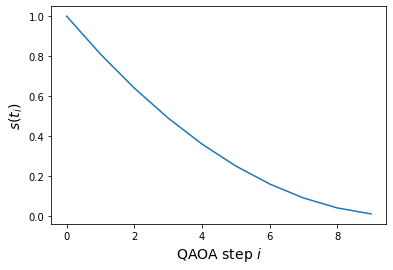

In [12]:
p = 10
schedule = [((p-i)/p)**2 for i in range(p)]

plt.plot(range(p),schedule)
plt.xlabel("QAOA step $i$", fontsize=14)
plt.ylabel("$s(t_i)$", fontsize=14)
plt.show()

In [14]:
annealing_params = AnnealingParams([hamiltonian],schedule)
print(abstract_params)

ValueError: not enough values to unpack (expected 2, got 1)

## The `Fourier` parameter class

This parameter class originated from attempts to find heuristic ways of reducing the number of parameters required to perform QAOA. Based on empirical observations in patterns of the optimal QAOA angles, Zhuo et al (see [Ref 2](#references)) proposed considering the discrete Fourier transforms of `betas` and `gammas` as an alternative, more economical parametrisation.

The basic idea kicks off from  the conventional QAOA parametrisation, what we call the `StandardParams` class. Here, at each iteration in QAOA we have one angle for all of the mixer Hamiltonian terms, and one angle for all of the cost Hamiltonian terms. That is, the parametrisation requires the specification of $2p$ numbers, a `beta` and a `gamma` for each timestep.

In the Fourier representation, we switch instead to a set of $2q$ parameters, denoted $\vec{v}$ and $\vec{u}$, which are related to $\vec{\beta}$ and $\vec{\gamma}$ by

\begin{eqnarray}
\beta_i^{(p)} &=& \sum_{k=1}^q v_k \cos\left[ \left(k - \frac{1}{2}\right) \left(i - \frac{1}{2}\right) \frac{\pi}{p} \right]\\
\gamma_i^{(p)} &=& \sum_{k=1}^q u_k \sin\left[ \left(k - \frac{1}{2}\right) \left(i - \frac{1}{2}\right) \frac{\pi}{p} \right]
\end{eqnarray}

where $i = 1,...,p$. The insight of Zhou et al is that the optimal parameters are often smoothly varying functions, and that it should then be possible to use a reduced parameter set consisting of only the lowest $q$ frequency components of those functions. Clearly, for $q\geq p$ we have the full expressivity of the original parameter set (i.e. the $\beta$s and $\gamma$s).

In this parametrisation, for fixed $q$ the optimisation problem therefore becomes that of finding the optimal Fourier components $v_k$ and $u_k$. In our implementation, we further allow for the single-qubit bias terms and the two-qubit pair terms to have different angles, so that we in fact have $3q$ parameters:

\begin{eqnarray}
\beta_i^{(p)} &=& \sum_{k=1}^q v_k \cos\left[ \left(k - \frac{1}{2}\right) \left(i - \frac{1}{2}\right) \frac{\pi}{p} \right]\\
\gamma_{s_i}^{(p)} &=& \sum_{k=1}^q u_{s_k} \sin\left[ \left(k - \frac{1}{2}\right) \left(i - \frac{1}{2}\right) \frac{\pi}{p} \right] \\
\gamma_{\Pi_i}^{(p)} &=& \sum_{k=1}^q u_{\Pi_k} \sin\left[ \left(k - \frac{1}{2}\right) \left(i - \frac{1}{2}\right) \frac{\pi}{p} \right]
\end{eqnarray}

Let's set up `Fourier` parameters for the simple three-qubit problem considered above, with $p=3$ and keeping only the lowest frequency component, i.e. $q = 1$. This requires us to provide only 3 input parameters:

In [6]:
Term1 = PauliTerm("Z", 0, 0.7)*PauliTerm("Z", 1)
Term2 = PauliTerm("Z", 0, 1.2)*PauliTerm("Z", 2)
Term3 = PauliTerm("Z", 0, -0.5)

hamiltonian = PauliSum([Term1,Term2,Term3])
p = 3
q = 1

v_param = np.random.rand(q)
u_singles_param = np.random.rand(q)
u_pairs_param = np.random.rand(q)

params = (v_param, u_singles_param, u_pairs_param)
fourier_params = FourierParams([hamiltonian, p, q], params)
print(fourier_params)

Hyperparameters:
	register: [0, 1, 2]
Parameters:
	u_singles: [0.6671246]
	u_pairs: [0.67268401]
	v: [0.61485459]



<a id='references'></a>

## References

1. L. Zhou et al, __[*Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices*](https://arxiv.org/abs/1812.01041)__